In [1]:
# basic libraries
import os
import numpy as np
import pandas as pd

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
#evaluation metrics
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# load outcome file containing mortality information
outcomes = pd.read_csv(
    "/kaggle/input/predict-mortality-of-icu-patients-physionet/Outcomes-a.txt"
)

#select only required columns
outcomes = outcomes[['RecordID', 'In-hospital_death']]
#display first few rows
outcomes.head()


,RecordID,In-hospital_death
0,132539,0
1,132540,0
2,132541,0
3,132543,0
4,132545,0


In [3]:
#path to ICU patient records
data_path = "/kaggle/input/predict-mortality-of-icu-patients-physionet/set-a/set-a"

records = []

#loop through each patient file
for file in os.listdir(data_path):
    file_path = os.path.join(data_path, file)
    #read patient data
    df = pd.read_csv(file_path)

    #extract patient RecordID
    record_id = int(file.replace(".txt", ""))
    
    # take mean of numeric columns
    features = df.groupby("Parameter")["Value"].mean()
    features["RecordID"] = record_id
    
    records.append(features)

#convert list to dataframe
data = pd.DataFrame(records)
data.head()


Parameter,ALT,Age,Albumin,BUN,Cholesterol,Creatinine,GCS,Gender,Glucose,HCO3,...,PaO2,SysABP,pH,ALP,AST,Bilirubin,SaO2,RespRate,TroponinT,TroponinI
Value,52.0,66.0,3.5,18.500000,199.0,1.200000,15.000000,1.0,115.50,29.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Value,NaN,50.0,NaN,11.250000,NaN,0.775000,6.880000,1.0,163.00,22.000000,...,175.000000,126.685185,7.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Value,57.0,40.0,NaN,8.666667,NaN,0.733333,7.647059,1.0,164.00,21.333333,...,127.117647,157.634146,7.362353,33.0,109.0,0.7,NaN,NaN,NaN,NaN
Value,NaN,58.0,NaN,24.750000,NaN,1.100000,13.500000,1.0,158.25,26.000000,...,147.600000,113.861111,7.360909,NaN,NaN,NaN,96.625,NaN,NaN,NaN
Value,NaN,80.0,NaN,NaN,NaN,NaN,15.000000,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.372549,NaN,NaN


In [4]:
#merge patient features with mortality outcome
dataset = pd.merge(data, outcomes, on="RecordID")
dataset.head()

,ALT,Age,Albumin,BUN,Cholesterol,Creatinine,GCS,Gender,Glucose,HCO3,...,SysABP,pH,ALP,AST,Bilirubin,SaO2,RespRate,TroponinT,TroponinI,In-hospital_death
0,52.0,66.0,3.5,18.500000,199.0,1.200000,15.000000,1.0,115.50,29.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,NaN,50.0,NaN,11.250000,NaN,0.775000,6.880000,1.0,163.00,22.000000,...,126.685185,7.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,57.0,40.0,NaN,8.666667,NaN,0.733333,7.647059,1.0,164.00,21.333333,...,157.634146,7.362353,33.0,109.0,0.7,NaN,NaN,NaN,NaN,0
3,NaN,58.0,NaN,24.750000,NaN,1.100000,13.500000,1.0,158.25,26.000000,...,113.861111,7.360909,NaN,NaN,NaN,96.625,NaN,NaN,NaN,0
4,NaN,80.0,NaN,NaN,NaN,NaN,15.000000,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,18.372549,NaN,NaN,0


In [5]:
#replace missing values with column mean
dataset.fillna(dataset.mean(), inplace=True)

In [6]:
# Separate input features and output label
X = dataset.drop(columns=["RecordID", "In-hospital_death"])
y = dataset["In-hospital_death"]

# Train–test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [7]:
# Standardize feature values
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
# Initialize Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Train the model
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [9]:
# Predict on test data
y_pred = model.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.86125


In [10]:
# Detailed performance metrics
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.87      0.98      0.92       679
           1       0.65      0.18      0.28       121

    accuracy                           0.86       800
   macro avg       0.76      0.58      0.60       800
weighted avg       0.84      0.86      0.83       800



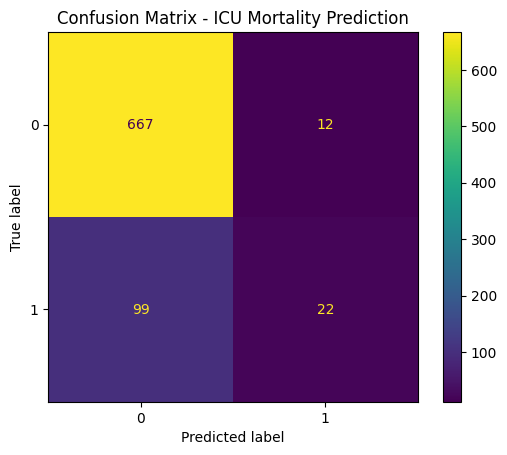

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    model, X_test, y_test
)

plt.title("Confusion Matrix - ICU Mortality Prediction")
plt.show()

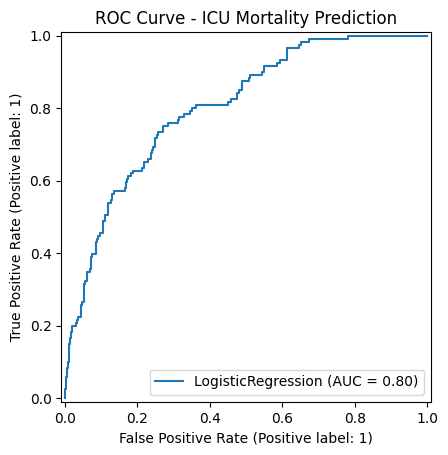

In [12]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(
    model, X_test, y_test
)

plt.title("ROC Curve - ICU Mortality Prediction")
plt.show()

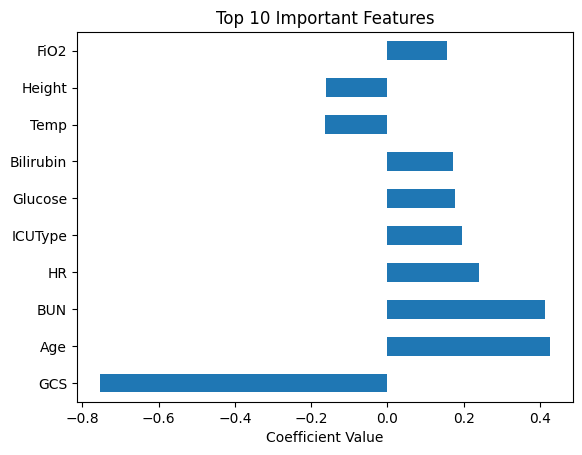

In [13]:
# Extract most influential features
importance = pd.Series(
    model.coef_[0],
    index=X.columns
).sort_values(key=abs, ascending=False)[:10]

importance.plot(kind='barh')
plt.title("Top 10 Important Features")
plt.xlabel("Coefficient Value")
plt.show()
